In [1]:
from functions import *

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool, cpu_count
from functools import partial

# **Flache and Macy Model**

First let's initialize the network and see that it looks like. 

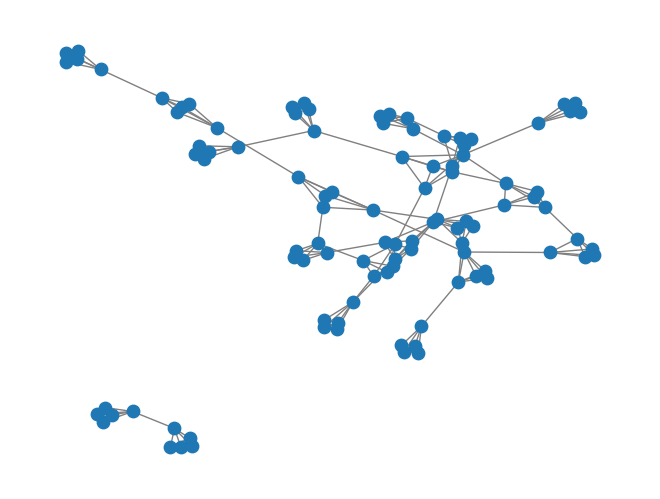

In [130]:
n_caves = 20  # number of groups 
n_members = 5   # number of nodes in each group

# create a cave-man network with 20 nodes in groups of 5
G = nx.connected_caveman_graph(n_caves, n_members)
G = initialize_network(n_caves, n_members, add_random_ties=True, p_random=0.003)

# pos = nx.spring_layout(G)
nx.draw(G, with_labels=False, node_size=80, edge_color='gray')
plt.show()

## **Only Positive influence**

First let's simulate the case without negative valence of interaction. This means that the weights are purely positive $w \in [0, +1]$. 

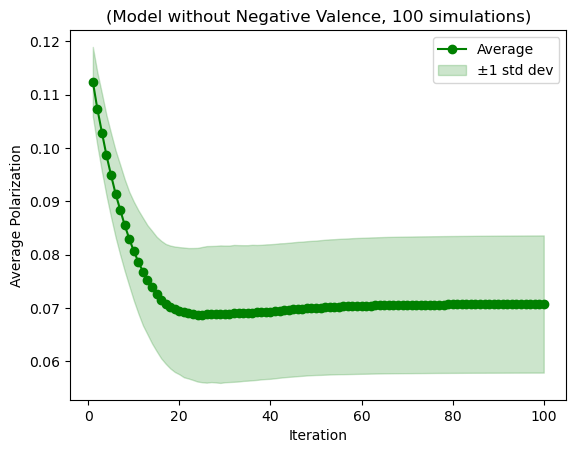

In [18]:
num_caves = 20
cave_size = 5               # N = 20 * 5 = 100 agents.
N = num_caves * cave_size
K = 2                       # Two opinion dimensions.
num_iterations = 100        # Each iteration = 100 time steps.
Nsims = 100                 # Run 50 independent simulations.
allow_negative = False      # Model without negative valence of interaction.

# Initialize the network (here, we do not add extra random ties)
G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)

# Container for polarization histories from each simulation
all_polarizations = []

def run_single_simulation(sim):
    # Reinitialize opinions and weights for each simulation
    S_sim = initialize_opinions(N, K)
    W_sim = compute_weights(S_sim, allow_negative=allow_negative)
    
    # Run the simulation for num_iterations iterations
    pol_history, S_final, W_final = run_simulation(G, S_sim, W_sim, num_iterations, allow_negative=allow_negative)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    all_polarizations.extend(pool.map(run_single_simulation, range(Nsims)))

all_polarizations = np.array(all_polarizations)  # Shape: (Nsims, num_iterations)
avg_polarization = np.mean(all_polarizations, axis=0)
std_polarization = np.std(all_polarizations, axis=0)

# Plot average polarization vs. iteration with confidence interval
x = range(1, num_iterations + 1)
plt.plot(x, avg_polarization, marker='o', color='green', label='Average')
plt.fill_between(x, 
                avg_polarization - std_polarization,
                avg_polarization + std_polarization,
                color='green', alpha=0.2, label='±1 std dev')
plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title(f"(Model without Negative Valence, {Nsims} simulations)")
plt.legend()
plt.show()

In [19]:
# PARAMETERS
num_caves = 20
cave_size = 5         # Total agents: N = num_caves * cave_size = 100
N = num_caves * cave_size
K = 2                 # Number of opinion dimensions
num_iterations = 100  # Number of iterations (each iteration = N time steps)
Nsims = 100           # Number of simulation runs for each condition
allow_negative = False

# p for adding random ties when they are added either at initialization or later:
p_random_initial = 0.03   # Condition 3: ties at initialization
p_random_later = 0.03     # Condition 2: ties added after iteration 50

# We'll store the average polarization history (an array of length num_iterations) for each condition.
all_avg_pol = {}

# ---------- Condition 1: Disconnected Caveman Graph ----------
# No random ties added either at initialization or later.
pol_histories_cond1 = []

def run_single_sim_cond1(_):  # Add parameter to accept the iteration number (unused)
    # Create a disconnected caveman graph
    G1 = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.003)
    # Initialize opinions and weights
    S1 = initialize_opinions(N, K)
    W1 = compute_weights(S1, allow_negative=allow_negative)
    
    # Run simulation with no additional tie injection (tie_addition_iter = None)
    pol_history, S1_final, W1_final = run_simulation(G1, S1, W1, num_iterations,
                                                    allow_negative=allow_negative,
                                                    tie_addition_iter=None,
                                                    p_random_new=None)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond1.extend(pool.map(run_single_sim_cond1, range(Nsims)))

# Average over runs (axis=0 gives an average for each iteration)
pol_histories_cond1 = np.array(pol_histories_cond1)
avg_pol_cond1 = np.mean(pol_histories_cond1, axis=0)
all_avg_pol['Disconnected'] = avg_pol_cond1

print("Done with Condition 1")

# ---------- Condition 2: Disconnected Graph with Ties Added at Iteration 50 ----------
# Start with a disconnected caveman graph; then, after iteration 50, add random ties with p=0.03.
pol_histories_cond2 = []

def run_single_sim_cond2(_):  # Add parameter to accept the iteration number (unused)
    G2 = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.003)
    S2 = initialize_opinions(N, K)
    W2 = compute_weights(S2, allow_negative=allow_negative)
    
    # Here we specify tie_addition_iter=50, so that after 50 iterations new ties are added.
    pol_history, S2_final, W2_final = run_simulation(G2, S2, W2, num_iterations,
                                                     allow_negative=allow_negative,
                                                     tie_addition_iter=50, 
                                                     p_random_new=p_random_later)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond2.extend(pool.map(run_single_sim_cond2, range(Nsims)))

# Average over runs (axis=0 gives an average for each iteration)
pol_histories_cond2 = np.array(pol_histories_cond2)
avg_pol_cond2 = np.mean(pol_histories_cond2, axis=0)
all_avg_pol['Delayed Ties (iter=50)'] = avg_pol_cond2

print("Done with Condition 2")

# ---------- Condition 3: Caveman Graph with Random Ties at Initialization ----------
# Create a caveman graph that already has random ties (with p=0.03) at the outset.
pol_histories_cond3 = []

def run_single_sim_cond3(_):  # Add parameter to accept the iteration number (unused)
    G3 = initialize_network(num_caves, cave_size, add_random_ties=True, p_random=p_random_initial)
    S3 = initialize_opinions(N, K)
    W3 = compute_weights(S3, allow_negative=allow_negative)
    
    # Run simulation with no later tie addition.
    pol_history, S3_final, W3_final = run_simulation(G3, S3, W3, num_iterations,
                                                     allow_negative=allow_negative,
                                                     tie_addition_iter=None,
                                                     p_random_new=None)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond3.extend(pool.map(run_single_sim_cond3, range(Nsims)))

pol_histories_cond3 = np.array(pol_histories_cond3)
avg_pol_cond3 = np.mean(pol_histories_cond3, axis=0)
all_avg_pol['Initial Ties'] = avg_pol_cond3

print("Done with Condition 3")

Done with Condition 1
Done with Condition 2
Done with Condition 3


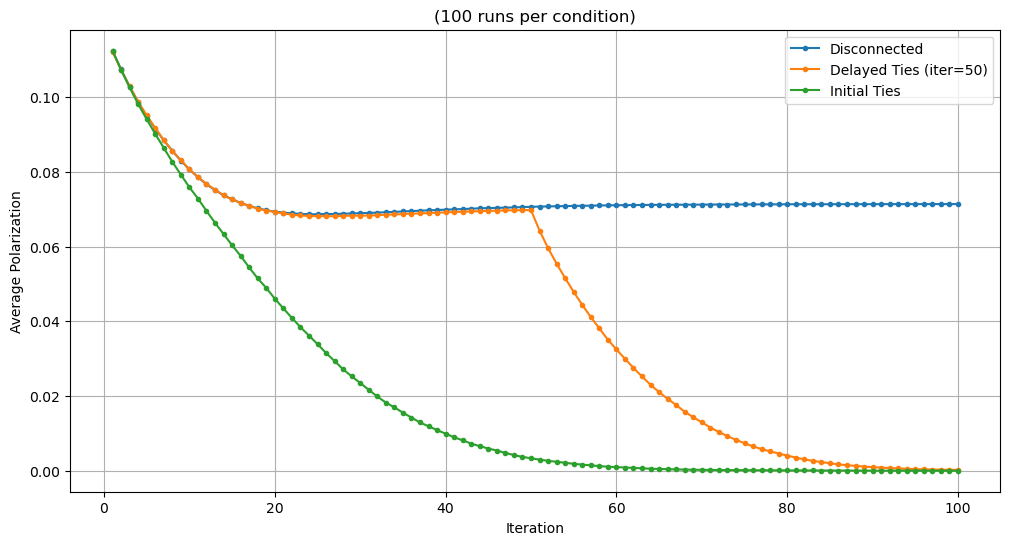

In [27]:
fig = plt.figure(figsize=(12, 6))
iterations = np.arange(1, num_iterations+1)

for label, avg_pol in all_avg_pol.items():
    plt.plot(iterations, avg_pol, marker='.', label=label)

plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title("(100 runs per condition)")
plt.legend()
plt.grid(True)
plt.show()

## **Allowing Negative Valence**

Now let's allow the valence to be negative. This means that the weights are now $w \in [-1, +1]$. 

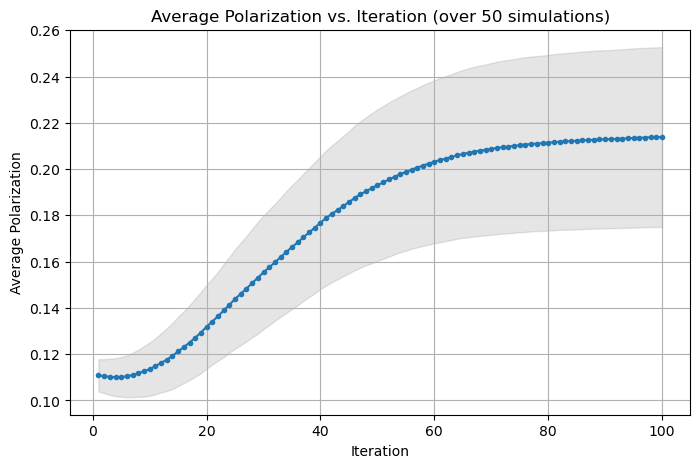

In [30]:
Nsims = 50  # Number of independent simulations
all_polarizations = []  # To store polarization histories for each simulation
num_iterations = 100

# For each simulation, we reinitialize opinions (and weights) but use the same network G.
for sim in range(Nsims):
    S_sim = initialize_opinions(N, K)        # Reinitialize opinions
    W_sim = compute_weights(S_sim)           # Compute initial weights based on S_sim
    
    # Run simulation for this replicate
    pol_history, S_final, W_final = run_simulation(G, S_sim, W_sim, num_iterations)
    all_polarizations.append(pol_history)

# Convert to numpy array: shape (Nsims, num_iterations)
all_polarizations = np.array(all_polarizations)

# Compute the average polarization at each iteration across simulations
avg_polarization = np.mean(all_polarizations, axis=0)
std_polarization = np.std(all_polarizations, axis=0)

# Plot average polarization vs. iteration number
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_iterations + 1), avg_polarization, marker='.')
plt.fill_between(range(1, num_iterations + 1), 
                avg_polarization - std_polarization,
                avg_polarization + std_polarization,
                color='blue', alpha=0.2)
plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title(f"Average Polarization vs. Iteration (over {Nsims} simulations)")
# plt.grid(True)
plt.show()

## **Lee Model** 

First let's simulate a single run of the Lee model. 

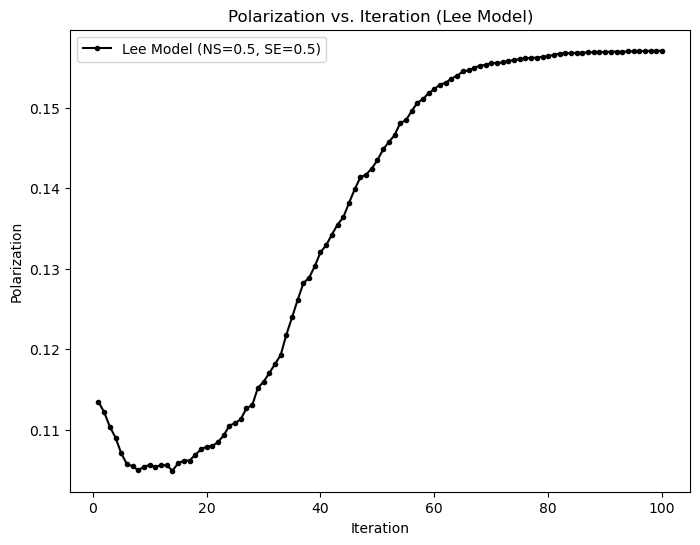

In [134]:
# ---------------------------
# PARAMETERS
# ---------------------------
num_caves       = 20             # Number of caves/clusters
cave_size       = 5              # Nodes per cave; total agents N = num_caves * cave_size
N               = num_caves * cave_size
K               = 2              # Number of opinion dimensions
NS              = 0.5            # Fraction of dimensions that are segregated
SE              = 0.5            # Structural Embeddedness parameter (0 <= SE <= 1)
num_iterations  = 100            # Each iteration = N time steps
allow_negative  = True           # Using negative influence allowed (default for Lee)
tie_addition_iter = None         # No extra tie addition later
p_random_new    = None           # Not needed if no tie addition

# ---------------------------
# INITIALIZATION
# ---------------------------
# Create a caveman network without random ties added at initialization
G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)

# Initialize opinions using the Lee model version.
# This function assigns segregated opinions for a fraction NS of the dimensions.
# It also returns a groups vector (which we don't use further here, but is available for analysis).
S = initialize_opinions_Lee(N, K, NS, cave_size)

# Compute the initial weight matrix (using the standard function)
W = compute_weights(S, allow_negative=allow_negative)

# ---------------------------
# RUN SIMULATION (LEE MODEL)
# ---------------------------
# run_simulation_Lee() uses the pre-computed tie activation probability matrix T (based on SE)
polarization_history, S_final, W_final = run_simulation_Lee(
    graph = G,
    S = S,
    W = W,
    num_iterations = num_iterations,
    SE = SE,
    allow_negative = allow_negative,
    tie_addition_iter = tie_addition_iter,
    p_random_new = p_random_new
)

# ---------------------------
# PLOTTING RESULTS
# ---------------------------
iterations = np.arange(1, num_iterations + 1)
plt.figure(figsize=(8, 6))
plt.plot(iterations, polarization_history, marker='.', color='black', label="Lee Model (NS=0.5, SE=0.5)")
plt.xlabel("Iteration")
plt.ylabel("Polarization")
plt.title("Polarization vs. Iteration (Lee Model)")
plt.legend()
# plt.grid(True)
plt.show()

### **Recreating the Flache and Macy Model**

$$NS = 0$$
$$SE = 0$$

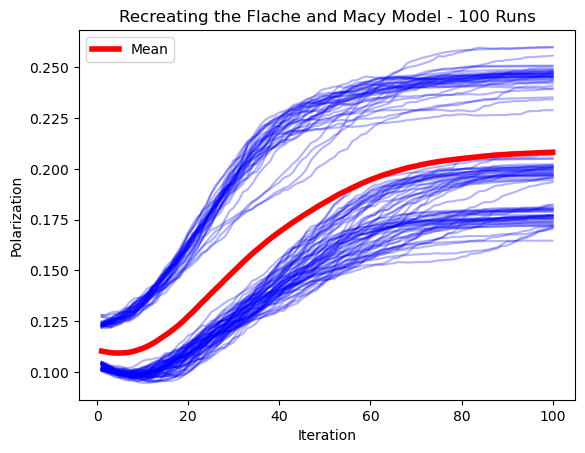

In [42]:
num_runs = 100
all_polarization_histories = []
num_caves       = 20             # Number of caves/clusters
cave_size       = 5              # Nodes per cave; total agents N = num_caves * cave_size
N               = num_caves * cave_size
K               = 2              # Number of opinion dimensions
NS              = 0.0            # Fraction of dimensions that are segregated
SE              = 0.0            # Structural Embeddedness parameter (0 <= SE <= 1)
num_iterations  = 100            # Each iteration = N time steps
allow_negative  = True           # Using negative influence allowed (default for Lee)
tie_addition_iter = None         # No extra tie addition later
p_random_new    = None           # Not needed if no tie addition

# Create iterations array dynamically based on num_iterations
iterations = np.arange(1, num_iterations + 1)

def run_single_simulation(run, num_caves, cave_size, N, K, NS, allow_negative, num_iterations, SE, tie_addition_iter, p_random_new):
    # Create new network for each run
    G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)
    
    # Initialize new opinions for each run
    S = initialize_opinions_Lee(N, K, NS, cave_size)
    
    # Compute initial weights
    W = compute_weights(S, allow_negative=allow_negative)
    
    # Run simulation
    polarization_history, S_final, W_final = run_simulation_Lee(
        graph = G,
        S = S,
        W = W,
        num_iterations = num_iterations,
        SE = SE,
        allow_negative = allow_negative,
        tie_addition_iter = tie_addition_iter,
        p_random_new = p_random_new
    )
    
    return polarization_history

# Set up the parallel pool using all available cores
num_cores = cpu_count()
pool = Pool(processes=num_cores)

# Create partial function with fixed parameters
run_sim = partial(run_single_simulation, 
                 num_caves=num_caves,
                 cave_size=cave_size,
                 N=N,
                 K=K,
                 NS=NS,
                 allow_negative=allow_negative,
                 num_iterations=num_iterations,
                 SE=SE,
                 tie_addition_iter=tie_addition_iter,
                 p_random_new=p_random_new)

# Run simulations in parallel
all_polarization_histories = pool.map(run_sim, range(num_runs))
pool.close()
pool.join()

# Plot each trajectory with some transparency
for polarization_history in all_polarization_histories:
    plt.plot(iterations, polarization_history, alpha=0.3, color='blue')

# Plot mean trajectory with higher opacity
mean_polarization = np.mean(all_polarization_histories, axis=0)
plt.plot(iterations, mean_polarization, color='red', linewidth=4, label='Mean')

plt.xlabel("Iteration")
plt.ylabel("Polarization")
plt.title(f"Recreating the Flache and Macy Model - {num_runs} Runs")
plt.legend()
plt.show()

Showcasing the stochasticity of the Lee Model

In [ ]:
num_runs = 100
all_polarization_histories = []
num_caves       = 20             # Number of caves/clusters
cave_size       = 5              # Nodes per cave; total agents N = num_caves * cave_size
N               = num_caves * cave_size
K               = 2              # Number of opinion dimensions
NS              = 0.5            # Fraction of dimensions that are segregated
SE              = 0.5            # Structural Embeddedness parameter (0 <= SE <= 1)
num_iterations  = 100            # Each iteration = N time steps
allow_negative  = True           # Using negative influence allowed (default for Lee)
tie_addition_iter = None         # No extra tie addition later
p_random_new    = None           # Not needed if no tie addition

# Create iterations array dynamically based on num_iterations
iterations = np.arange(1, num_iterations + 1)

def run_single_simulation(run, num_caves, cave_size, N, K, NS, allow_negative, num_iterations, SE, tie_addition_iter, p_random_new):
    # Create new network for each run
    G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)
    
    # Initialize new opinions for each run
    S = initialize_opinions_Lee(N, K, NS, cave_size)
    
    # Compute initial weights
    W = compute_weights(S, allow_negative=allow_negative)
    
    # Run simulation
    polarization_history, S_final, W_final = run_simulation_Lee(
        graph = G,
        S = S,
        W = W,
        num_iterations = num_iterations,
        SE = SE,
        allow_negative = allow_negative,
        tie_addition_iter = tie_addition_iter,
        p_random_new = p_random_new
    )
    
    return polarization_history

# Set up the parallel pool using all available cores
num_cores = cpu_count()
pool = Pool(processes=num_cores)

# Create partial function with fixed parameters
run_sim = partial(run_single_simulation, 
                 num_caves=num_caves,
                 cave_size=cave_size,
                 N=N,
                 K=K,
                 NS=NS,
                 allow_negative=allow_negative,
                 num_iterations=num_iterations,
                 SE=SE,
                 tie_addition_iter=tie_addition_iter,
                 p_random_new=p_random_new)

# Run simulations in parallel
all_polarization_histories = pool.map(run_sim, range(num_runs))
pool.close()
pool.join()


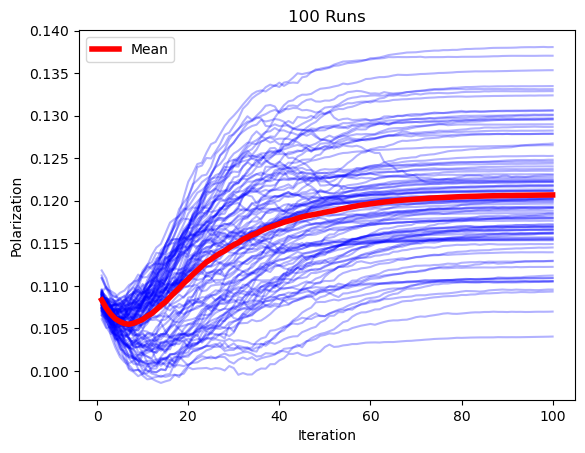

In [67]:
# Plot each trajectory with some transparency
for polarization_history in all_polarization_histories:
    plt.plot(iterations, polarization_history, alpha=0.3, color='blue')

# Plot mean trajectory with higher opacity
mean_polarization = np.mean(all_polarization_histories, axis=0)
plt.plot(iterations, mean_polarization, color='red', linewidth=4, label='Mean')

plt.xlabel("Iteration")
plt.ylabel("Polarization")
plt.title(f"{num_runs} Runs")
plt.legend()
plt.show()

Let's compare the distribution of final polarization for the Flache and Macy Model and the Lee Model.

In [143]:
## Perform 100 runs of the Flache and Macy Model and record the final polarization for each run. 

num_runs = 100
final_polarization_FM = []

# run the simulation for each run
for run in range(num_runs):

    G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)
    S = initialize_opinions(N, K)
    W = compute_weights(S, allow_negative=allow_negative)
    
    pol_history, S_final, W_final = run_simulation(G, S, W, num_iterations)
    final_polarization_FM.append(pol_history[-1])


Text(0.5, 1.0, '(Flache and Macy Model)')

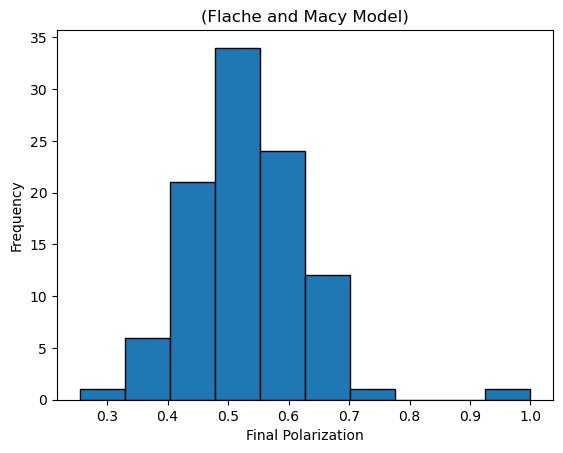

In [144]:
# NORMALIZE BETWEEN 0 AND 1
final_polarization_FM = final_polarization_FM / np.max(final_polarization_FM)

plt.hist(final_polarization_FM, edgecolor='black')
plt.xlabel("Final Polarization")
plt.ylabel("Frequency")
plt.title("(Flache and Macy Model)")

In [126]:
## Perform 100 runs of the Lee Model and record the final polarization for each run.

num_runs = 100
num_caves       = 20             # Number of caves/clusters
cave_size       = 5              # Nodes per cave; total agents N = num_caves * cave_size
N               = num_caves * cave_size
K               = 2              # Number of opinion dimensions
NS              = 1/2            # Fraction of dimensions that are segregated
SE              = 0.5            # Structural Embeddedness parameter (0 <= SE <= 1)
num_iterations  = 100            # Each iteration = N time steps
allow_negative  = True           # Using negative influence allowed (default for Lee)
tie_addition_iter = None         # No extra tie addition later
p_random_new    = None           # Not needed if no tie addition

final_polarization_Lee = []

# run simulation for each run
for run in range(num_runs):
    G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)
    S = initialize_opinions_Lee(N, K, NS, cave_size)
    W = compute_weights(S, allow_negative=allow_negative)
    pol_history, S_final, W_final = run_simulation_Lee(G, S, W, num_iterations, SE, allow_negative, tie_addition_iter, p_random_new)
    final_polarization_Lee.append(pol_history[-1])

# from multiprocessing import Pool, cpu_count

# def run_single_simulation(run):
#     G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)
#     S = initialize_opinions_Lee(N, K, NS, cave_size)
#     W = compute_weights(S, allow_negative=allow_negative)
    
#     pol_history, S_final, W_final = run_simulation_Lee(G, S, W, num_iterations, SE, allow_negative, tie_addition_iter, p_random_new)
#     return pol_history[-1]

# # Use all available CPU cores
# num_cores = cpu_count()
# with Pool(num_cores) as pool:
#     final_polarization_Lee = pool.map(run_single_simulation, range(num_runs))

Text(0.5, 1.0, '(Lee Model)')

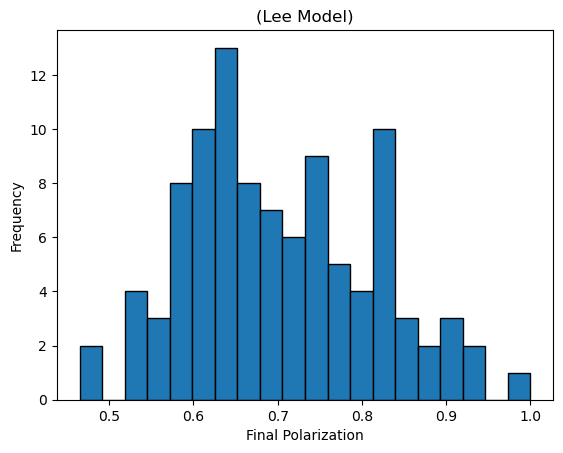

In [127]:
final_polarization_Lee = final_polarization_Lee / np.max(final_polarization_Lee)

plt.hist(final_polarization_Lee, bins=20, edgecolor='black')
plt.xlabel("Final Polarization")
plt.ylabel("Frequency")
plt.title("(Lee Model)")

Text(0.5, 1.0, 'Distribution of Final Polarization (Flache and Macy Model and Lee Model)')

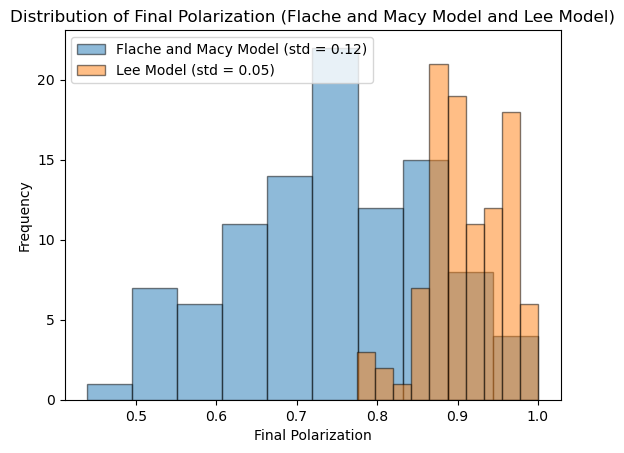

In [123]:
# PLOT THE DISTRIBUTION OF FINAL POLARIZATION FOR THE FLACHE AND MACY MODEL AND THE LEE MODEL

# compute the std deviation of each distribution
std_FM = np.std(final_polarization_FM)
std_Lee = np.std(final_polarization_Lee)

plt.hist(final_polarization_FM, edgecolor='black', label=f'Flache and Macy Model (std = {std_FM:.2f})', alpha=0.5)
plt.hist(final_polarization_Lee, edgecolor='black', label=f'Lee Model (std = {std_Lee:.2f})', alpha=0.5)

plt.xlabel("Final Polarization")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Final Polarization (Flache and Macy Model and Lee Model)")